# Линейные классификаторы и метрики качества
В этом ноутбуке рассмотрим несколько линейных классификаторов и метрики качества для оценки их работы.

# 1. Оценка качества модели

Процедуры оценки моделей.

1. **Натренироваться и тестироваться на одних и тех же данных**
    - Скорее всего приведет к переобучению и даст оценку только того, насколько хорошо запомнена выборка.
    
2. **Train/test split**
    - Разделить датасет на две части. Тренироваться на одной
    - Лучше чем п.1, но оценка всё равно не надежна 
    - Проста и быстра
3. **K-fold cross-validation**
    - Создать "K" разбиений на обучение и контроль посчитать среднюю ошибку на тестовых примерах
    - Гораздо лучшая точность
    - В "K" размедленнее

# 2. Метрики оценки моделей

**Для регрессий**:  
1. Mean Absolute Error(средняя абсолютная ошибка) $$ \large MAE = \frac{1}{n}\sum_{i=1}^{n}|f_i - y_i| $$
2. Mean Squared Error(среднеквадратичная ошибка) $$ \large  MSE = \frac{1}{n}\sum_{i=1}^{n}(f_i - y_i)^2  $$
3. Median Absolute Error(Медианная абсолютная ошибка) $$ \large  medae = median(\sum_{i=1}^{n}|f_i - y_i|)  $$

**Для классфикаций**:  
Accuracy(процент совпадений) $$\large accuracy(y,\hat{y}) = \frac{1}{n_{samples}}\sum_{i=0}^{n_{samples}-1}1(\hat{y_i}=y_i)$$

И еще очень много других.

# 4. Точность классификации

Набор данных по диабету среди некоторой популяции: [Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) из UCI Machine Learning Repository

In [1]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age','label']
pima = pd.read_csv(url, header=None, names=col_names)

In [2]:
# print the first 5 rows of data from the dataframe
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


label
    1: Диабет
    0: нет диабета

Вопрос: Можно ли предсказать диабет по некоторым измерениям?

In [3]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']

# X is a matrix, hence we use [] to access the features we want in feature_cols
X = pima[feature_cols]

# y is a vector, hence we use dot to access 'label'
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Точность классификации:** процент правильных предсказаний

In [7]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333


# Точность - 69%

**Базовая точность(null accuracy):** точность, которая достигается при предсказании самого частого класса.
Всегда сравниваем с этой точностью.

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [9]:
# calculate the percentage of ones
# because y_test only contains ones and zeros, we can simply calculate the mean = percentage of ones
y_test.mean()

0.32291666666666669

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.67708333333333326

In [11]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.67708333333333326

Модель, которая ставит только 0, будет права в 68% случаев:
- Видно, что модель классификации будет не так хороша, если она близка к тупой модели.
- Всегда неплохо знать тот минимум, который мы должны достичь в нашей модели.

In [12]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [13]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('False:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
False: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Вывод:**

- Точность классификации - **базовая метрика классификации**
- Но она ничего не говорит о  **распределении** ответов
- Ничего не говорит о **"типах" ошибок** которые мы делаем

# 5.  Матрица ошибок

Описывает качество работы классификатора

In [14]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](09_confusion_matrix_1.png)

- Каждое вхождение из тестового множества попадает **точно в одну ячейку**
- Матрица размера 2x2 - **2 класса ответов**
- Этот формат не универсален

**Basic terminology**

- **True Positives (TP):** мы *правильно* предсказали *наличие* диабета
    - 15
- **True Negatives (TN):** мы *правильно* предсказали *отсутствие* диабета
    - 118
- **False Positives (FP):** мы *неправильно* предсказали *наличие* диабета ("ошибка первого типа")
    - 12
    - Ошибочно предсказано наличие
    - Ошибка первого типа
- **False Negatives (FN):** мы *неправильно* предсказали *отсутствие* диабета ("ошибка второго типа")
    - 47
    - ошибочно предсказано отсутствие
    - ошибка второго рода

- 0: "негативный" класс
- 1: "позитивный" класс

In [15]:
# print the first 25 true and predicted responses
print('True', y_test.values[0:25])
print('Pred', y_pred_class[0:25])

True [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[118  12]
 [ 47  15]]


![Large confusion matrix](09_confusion_matrix_2.png)

# 6. Метрики из матрицы ошибок

**Точность классификации:** Вообще, насколько часто классификатор прав?
$$ \large \frac{TP+TN}{TP+TN+FP+FN}$$

In [17]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.692708333333
0.692708333333


**Ошибка классификации:** Как часто классификатор не прав?

- aka "Misclassification Rate"

$$ \large \frac{FP+FN}{TP+TN+FP+FN}$$

In [18]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.307291666667
0.307291666667


**Полнота(Recall):** Когда на самом деле класс = 1, насколько часто наше предсказание верно?
- Что-то, что мы хотим максимизировать
- ака "True Positive Rate" или "Recall" или "чувствительность"

$$ \large Recall = \frac{TP}{TP+FN}$$

In [19]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.241935483871
0.241935483871


**Специфичность:** Когда на самом деле класс был 0, как часто мы угадывали?
Используется в медицине.

$$\large  specificity = \frac{TN}{TN+FP} $$

In [20]:
specificity = TN / (TN + FP)

print(specificity)

0.907692307692


Наш классификатор
- Очень специфичен
- не чувствителен

**Точность**: Насколько часто, когда мы предсказываем класс 1 мы действительно оказываемся правы?

$$ \large Precision = \frac{TP}{TP+FP} $$

In [21]:
precision = TP / (TP + FP)

print(precision)

0.555555555556


**False Positive Rate:** Когда на самом деле 0, насколько часто предсказание неправильно?

In [22]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0923076923077
0.0923076923077


Есть еще много других метрик!

#### Арифметическое среднее
$$\large A = \frac{precision + recall}{2}$$

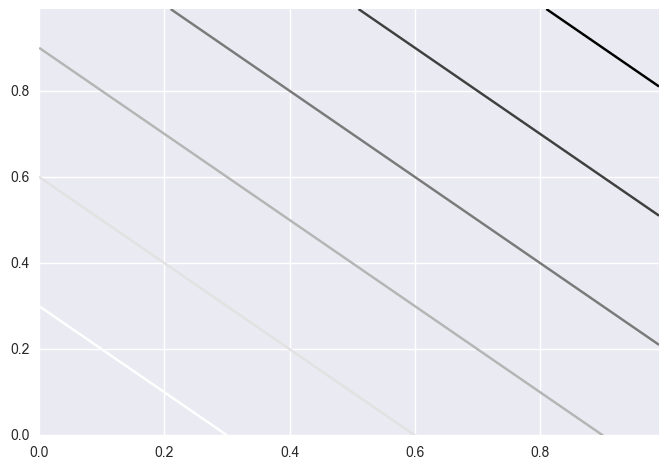

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pr = np.arange(0,1, 0.01)
rec = np.arange(0,1, 0.01)
A = np.zeros((100,100))
for idxx, x in enumerate(pr):
    for idxy, y in enumerate(rec):
        A[idxx][idxy] = (x + y) /2
        
plt.contour(pr,rec, A)
plt.show()

### F1-мера

$$ \large F = \frac{2 * precision * recall}{precision + recall} $$ 

In [24]:
metrics.f1_score(y_pred_class, y_test)

0.3370786516853933

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


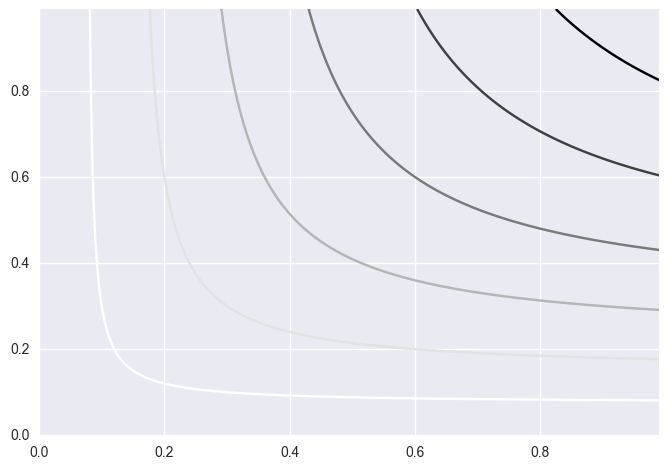

In [25]:
import numpy as np
pr = np.arange(0,1, 0.01)
rec = np.arange(0,1, 0.01)
A = np.zeros((100,100))
for idxx, x in enumerate(pr):
    for idxy, y in enumerate(rec):
        A[idxx][idxy] = (2*x*y) /(x+y)
        
plt.contour(pr,rec, A)
plt.show()

**Вывод:**

- Матрица ошибок дает понимание того, как работает классификатор
- Дает некоторое количество метрик, которые потом помогут в выборе моделей

**На каких метриках стоит сфокусироваться?**

- Выбор метрик зависит от **"целей бизнеса"**
    - нужно выбрать, что важнее уменьшать - FP или FN
    - Выбрать метрику с более нужной переменной (FP или FN в уравнении)
- **Фильтр спама** (1 = "spam"): 
    - Оптимизировать **точность(precision) или специфичность** 
    - Подбор false positive
    - Потому что false negative (spam в инбоксе) более приемлимы чем false positive ("проверьте папку спам")
- **Детектор фрода** (1 = "fraud"): 
    - Оптимизация **чувствительности**
        - подбор по false negative
    - Потому что false positive (обычные транзакции помеченные как мошенничество) более приемлимы чем false negative (мошенничество пропущено)

#  7. Подбор барьера для классификации

In [26]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [27]:
# print the first 10 predicted probabilities of class membership
logreg.predict_proba(X_test)[0:10]

array([[ 0.63247571,  0.36752429],
       [ 0.71643656,  0.28356344],
       [ 0.71104114,  0.28895886],
       [ 0.5858938 ,  0.4141062 ],
       [ 0.84103973,  0.15896027],
       [ 0.82934844,  0.17065156],
       [ 0.50110974,  0.49889026],
       [ 0.48658459,  0.51341541],
       [ 0.72321388,  0.27678612],
       [ 0.32810562,  0.67189438]])

- Строчка: наблюдение
    - для каждой строки сумма чисел равна 1
- Столбец: класс
    - 2 класс - 2 столбца
        - столбец 0: вероятность принадлежности к классу 0
        - столбец 1: вероятность принадлжности к классу 1 

In [28]:
# print the first 10 predicted probabilities for class 1
logreg.predict_proba(X_test)[0:10, 1]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [29]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [30]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# adjust the font size 
plt.rcParams['font.size'] = 12

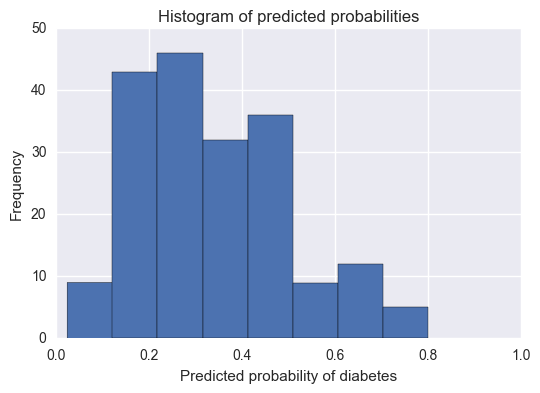

In [31]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

- Из графика видно
    - Около 45% наблюдений имеют вероятность от 0.2 до 0.3
    - Не очень большое количество наблюдений с вероятностью > 0.5
    - Барьер 0.5 не очень подходит
    - Пропустим всех диабетиков
- Решение
    - **Понизить барьер**
        - **Повысить чувствительность**
            - Должно повыситься количество TP
                - Больше чувствительность к диабетикам
                - Пример детектора металла
                    - Барьер ставится для реакции на большие объекты и пропуск небольших
                    - YES: металл, NO: не металл
                    - Понижаем барьер, чтобы детектировать больше металла
                    - Детектор более чувствителен
                    - Теперь он чаще срабатывает

In [32]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob.reshape(1,-1), 0.3)[0]

In [33]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([ 0.36752429,  0.28356344,  0.28895886,  0.4141062 ,  0.15896027,
        0.17065156,  0.49889026,  0.51341541,  0.27678612,  0.67189438])

In [34]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.])

In [35]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[118  12]
 [ 47  15]]


In [36]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[80 50]
 [16 46]]


In [37]:
# sensitivity has increased (used to be 0.24)
print (46 / float(46 + 16))

0.7419354838709677


In [38]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

0.6153846153846154


**Вывод:**

- **Уровень 0.5** используется как базовый для бинарных классификаций для превращения вероятностей в предсказания
- Уровень можно регулировать для изменения чувствительности и специфичности
- Чувствительность и специфичность обратно зависимы    

### 8. Receiver Operating Characteristic (ROC) Кривые

**Вопрос:** Неплохо было бы увидеть, как чувствительность и специфичность зависят от разных уровней барьера без изменений этого барьера?

**Ответ:** Построим ROC кривую.
- Receiver Operating Characteristic (ROC)

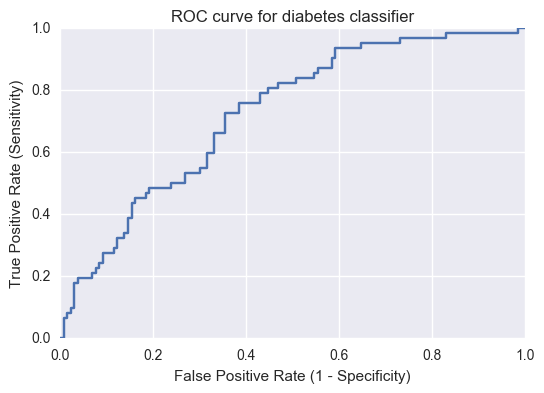

In [39]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

- ROC кривая поможет **выбрать барьер** для балансировки чувствительности и специфичности таким образом, который больше подходит по контексту задачи

In [40]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [41]:
evaluate_threshold(0.5)

Sensitivity: 0.241935483871
Specificity: 0.907692307692


In [42]:
evaluate_threshold(0.3)

Sensitivity: 0.725806451613
Specificity: 0.615384615385


### 9. AUC
AUC это **%** графика, попавшего под ROC кривую:

In [43]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.724565756824


- AUC полезен как оценка **одним числом** качества классификатора
- выше значение = лучше классификатор
- Для случайно выбранных негативного и позитивного примера AUC показывает вероятность того, что классификатор назначит более высокую вероятность позитивному примеру
- AUC полезен при сильном дисбалансе классов
    - Fraud case
        - Null почти 99%
        - AUC очень полезен

In [47]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, pima.label, cv=10, scoring='roc_auc').mean()

0.73782336182336183

Использовать совместно когда это только возможно:

1. **Матрица ошибок:**

    - Много  метрик    

2. **ROC/AUC advantages:**

    - Не надо выставлять барьеры
    - имеет смысл при дисбалансе классов

In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(y_pred_class, y_test))

             precision    recall  f1-score   support

        0.0       0.62      0.83      0.71        96
        1.0       0.74      0.48      0.58        96

avg / total       0.68      0.66      0.65       192

